In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

Channels and names used for recording:  
0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15  
MCLK1	DAT0	DAT1	DAT2	DAT3	DAT4	DAT5	DAT6	DAT7	DAT8	DAT9	DAT10	DAT11	DAT12	DAT13	DAT14

In [6]:
# fpath = "F:\\pp1_data_processing\\dat_bus2_split_contr.txt"
fpath = "F:\\pp1_data_processing\\dat_bus_split.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_min.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_max.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_red_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_enhancer_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_contrast_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_bright_cycle_from_all_50.txt"
# fpath = "F:\\pp1_data_processing\\dat_bus_.txt"
# fpath = "C:\\Users\\ionca\\Desktop\\pp1\\2023-06-02_16-37-18 dat_bus_example.csv"
# fpath = "F:\\pp1_data_processing\\2023-06-06_12-38-17  dat bus in standalone mode with adv mode cycling.csv"
df = pd.read_csv(fpath)

In [7]:
df.columns

Index(['Time[s]', ' MCLK1', ' DAT0', ' DAT1', ' DAT2', ' DAT3', ' DAT4',
       ' DAT5', ' DAT6', ' DAT7', ' DAT8', ' DAT9', ' DAT10', ' DAT11',
       ' DAT12', ' DAT13', ' DAT14'],
      dtype='object')

In [8]:
df.dtypes

Time[s]    float64
 MCLK1       int64
 DAT0        int64
 DAT1        int64
 DAT2        int64
 DAT3        int64
 DAT4        int64
 DAT5        int64
 DAT6        int64
 DAT7        int64
 DAT8        int64
 DAT9        int64
 DAT10       int64
 DAT11       int64
 DAT12       int64
 DAT13       int64
 DAT14       int64
dtype: object

In [31]:
dat0diffs = df[' DAT0'].diff()
chunk_indices_start = dat0diffs.index.to_series().loc[dat0diffs == -1.0] # falling edges
chunk_indices_end = dat0diffs.index.to_series().loc[dat0diffs == 1.0] # rising edges
chunk_indices_start = chunk_indices_start.to_list()
chunk_indices_end = chunk_indices_end.to_list()
print(len(chunk_indices_end), len(chunk_indices_start))
print(chunk_indices_start)
print(chunk_indices_end)

C:\Users\ionca\AppData\Local\Temp\ipykernel_9828\1852024884.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_onechunk.plot(x='Time[s]', y=df_onechunk.columns[1:], subplots=True, ax=ax)


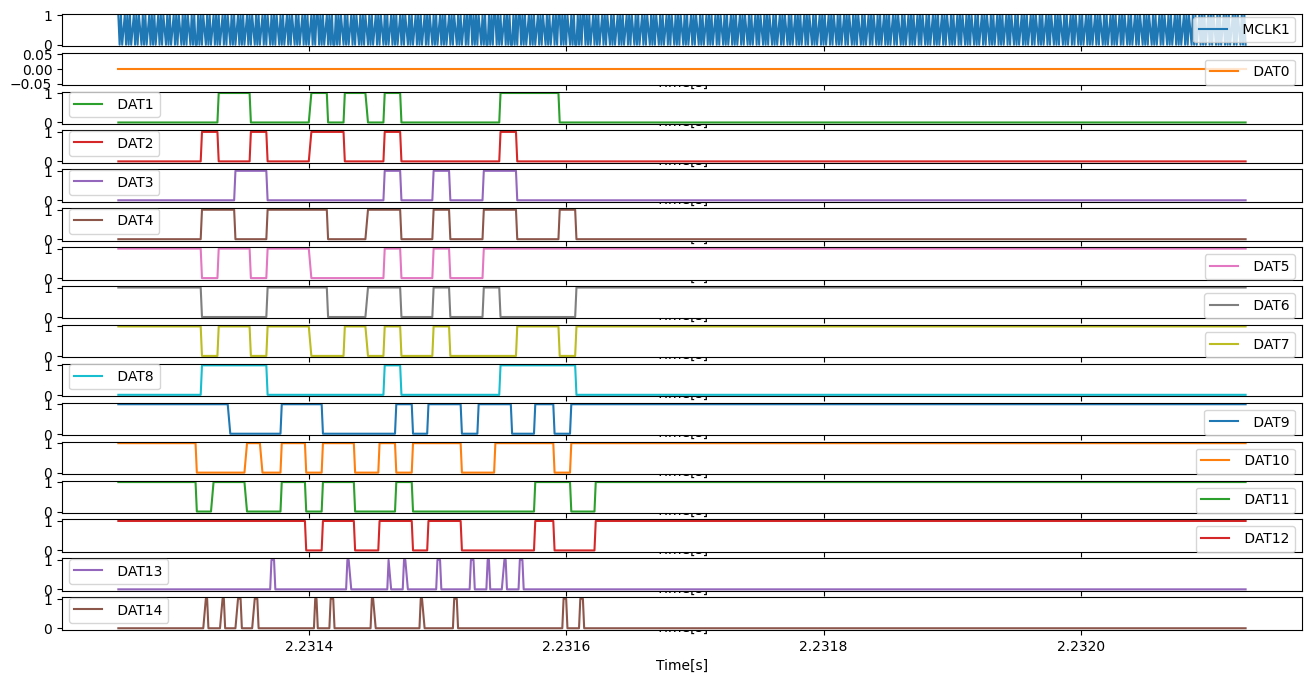

In [33]:
chunknum = 164
df_onechunk = df.iloc[chunk_indices_start[chunknum]:chunk_indices_end[chunknum],].copy()
fig,ax = plt.subplots()
fig.set_size_inches(16,8)
df_onechunk.plot(x='Time[s]', y=df_onechunk.columns[1:], subplots=True, ax=ax)
plt.show()

Assuming the rising edges of DAT13 and DAT14 define when the values of all other DAT lines get stored

In [9]:
dat13dat14rise = df_onechunk[' DAT13'] + df_onechunk[' DAT14']
dat13dat14rise = dat13dat14rise.diff()
dat13dat14rise = dat13dat14rise.loc[dat13dat14rise == 1]
dat13dat14rise = dat13dat14rise.index.to_series()
dat13dat14rise.shape

(20,)

In [44]:
# Get packet timing information
packet_lengths = [] # amount of time DAT0 is low
packet_wait_lengths = [] # amount of time between DAT0 going low and the first byte being transmitted
packet_active_data_lengths = [] # amount of time that the DAT13 and DAT14 lines are in use
packet_inactive_lengths = [] # amount of time that DAT0 remains low after DAT13 and DAT14 are done being used

for chunkstart, chunkend in zip(chunk_indices_start, chunk_indices_end):
    chunkdf = df.iloc[chunkstart:chunkend,]
    
    if chunkdf[' DAT14'].max() == 0:
        continue
    
    # packet length
    packet_length = chunkdf['Time[s]'].iloc[-1] - chunkdf['Time[s]'].iloc[0]
    packet_lengths.append(packet_length)
    
    # dat14 is always the first write to occur in a packet
    dat14diff = chunkdf[' DAT14'].diff()
    dat14_rising_edges = dat14diff.loc[dat14diff == 1]
    # get index of first rising edge on DAT14
    first_dat14_rising_edge = dat14_rising_edges.index.to_list()[0]
    
    # waiting time
    packet_wait = df['Time[s]'].iloc[first_dat14_rising_edge] - chunkdf['Time[s]'].iloc[0]
    packet_wait_lengths.append(packet_wait)
    
    # dat14 is always the last write to occur in a packet
    dat14_falling_edges = dat14diff.loc[dat14diff == -1]
    last_dat14_falling_edge = dat14_falling_edges.index.tolist()[-1]
    
    # active time
    packet_active = df['Time[s]'].iloc[last_dat14_falling_edge] - df['Time[s]'].iloc[first_dat14_rising_edge]
    packet_active_data_lengths.append(packet_active)
    
    # inactive time
    packet_inactive = packet_length - packet_wait - packet_active
    packet_inactive_lengths.append(packet_inactive)


# print averages
print("Averages:")
print("Packet Length:",np.mean(packet_lengths)*1_000_000, "us")
print("Wait Length:",np.mean(packet_wait_lengths)*1_000_000, "us")
print("Active Length:",np.mean(packet_active_data_lengths)*1_000_000, "us")
print("Inactive Length:",np.mean(packet_inactive_lengths)*1_000_000, "us")

Averages:
Packet Length: 875.5643564356467 us
Wait Length: 70.61386138619136 us
Active Length: 293.90759075903316 us
Inactive Length: 511.04290429042237 us


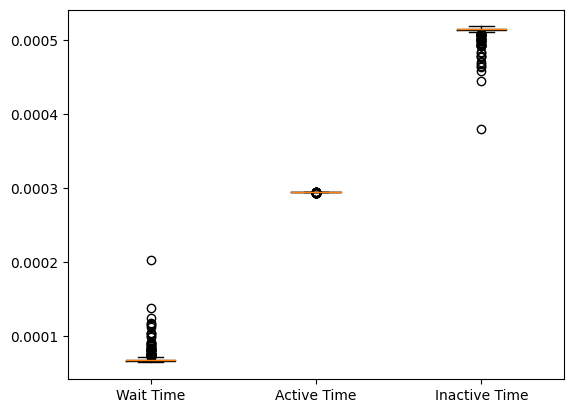

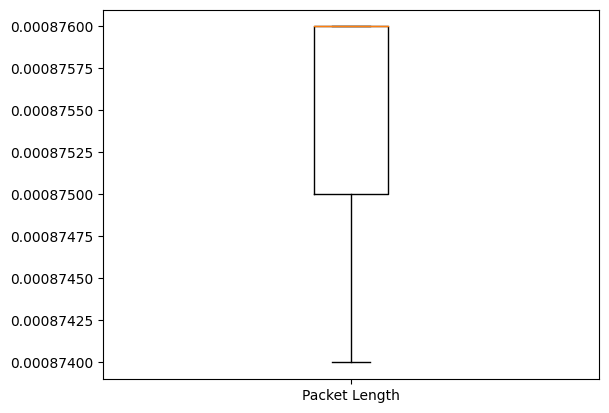

In [48]:
plt.boxplot([packet_wait_lengths, packet_active_data_lengths, packet_inactive_lengths], labels=['Wait Time', 'Active Time', 'Inactive Time'])
plt.show()
plt.boxplot(packet_lengths, labels=['Packet Length'])
plt.show()

In [14]:
chunkdatadf = df_onechunk.loc[dat13dat14rise,]

interesting note that MCLK1 is always low when there is a rising edge on dat13 or dat14 (only evident when data sample rate is >= 10MHz)

In [7]:
def converttodec(row, msbindex=0, lsbindex=-1, reverse=True):
    binlist = row.iloc[msbindex:lsbindex+1].to_list()
    if reverse:
        binlist.reverse()
    nbits = len(binlist)
    dec = 0
    for i in range(nbits):
        dec += binlist[i] * 2**i
    return dec        
    


In [27]:
chunkdatadf['VALUE'] = chunkdatadf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10), axis=1)
chunkdatadf['ADDRESS'] = chunkdatadf.apply(lambda x: converttodec(x, msbindex=11, lsbindex=14, reverse=True), axis=1)
chunkdatadf['BANK'] = chunkdatadf.apply(lambda x: 'A' if x.iloc[15] == 1 else 'B', axis=1)
chunkdatadf.reset_index(inplace=True, drop=True)
# chunkdatadf.sort_values('ADDRESS')
chunkdatadf

,Time[s],MCLK1,DAT0,DAT1,DAT2,DAT3,DAT4,DAT5,DAT6,DAT7,DAT8,DAT9,DAT10,DAT11,DAT12,DAT13,DAT14,VALUE,ADDRESS,BANK
0,2.231309,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,68,9,B
1,2.231322,1,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,149,11,B
2,2.231335,1,0,1,0,1,1,1,0,0,0,0,0,1,1,0,1,184,3,B
3,2.231348,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,1,103,5,B
4,2.231361,1,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,38,1,A
5,2.231394,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,174,8,B
6,2.231407,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,64,7,B
7,2.231420,1,0,1,0,0,0,0,0,1,0,0,1,1,1,1,0,130,7,A
8,2.231438,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,20,0,B
9,2.231451,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,0,255,5,A


# Process the entire timeseries

In [34]:
df_decimaldat1dat14 = pd.DataFrame()
for chunknumber in range(0, len(chunk_indices_start)):
    chunkdf = df.iloc[chunk_indices_start[chunknumber]:chunk_indices_end[chunknumber], :]
    
    dat13dat14rise = chunkdf[' DAT13'] + chunkdf[' DAT14']
    dat13dat14rise = dat13dat14rise.diff()
    dat13dat14rise = dat13dat14rise.loc[dat13dat14rise == 1]
    dat13dat14rise = dat13dat14rise.index.to_series()
    
    chunkdf = chunkdf.loc[dat13dat14rise,]
    
    #df_8bitdat1dat8[len(df_8bitdat1dat8.index),] = chunkdf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10), axis=1)
    vals = chunkdf.apply(lambda x: converttodec(x, msbindex=3, lsbindex=10, reverse=True), axis=1)
    if vals.empty:
        continue
    vals = vals.reset_index()
    vals = vals.drop(columns='index')

    vals = vals.T
    df_decimaldat1dat14 = pd.concat([df_decimaldat1dat14, vals], ignore_index=True)
    # df_8bitdat1dat8.insert(chunknumber, chunknumber, vals)
    

# df_8bitdat1dat8 = df_8bitdat1dat8.T
# oldcols = df_8bitdat1dat8.columns.tolist()
# newcols = ['val'+str(i) for i in range(20)]
# colmapper = dict(zip(oldcols, newcols))
# df_8bitdat1dat8.rename(colmapper, axis='columns', inplace=True)
# df_8bitdat1dat8.reset_index(inplace=True)
# df_8bitdat1dat8.drop(columns='index', inplace=True)
if df_decimaldat1dat14.shape[1] > 20:
    df_decimaldat1dat14.drop(columns=20, inplace=True)
    
df_decimaldat1dat14

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
1,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
2,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
3,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
4,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,241.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
299,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
300,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0
301,81.0,155.0,171.0,97.0,30.0,212.0,64.0,130.0,20.0,255.0,0.0,0.0,247.0,0.0,0.0,60.0,249.0,139.0,25.0,14.0


C:\Users\ionca\AppData\Local\Temp\ipykernel_9828\1126491182.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_decimaldat1dat14.plot(use_index=True,subplots=True, ax=ax) # show all


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

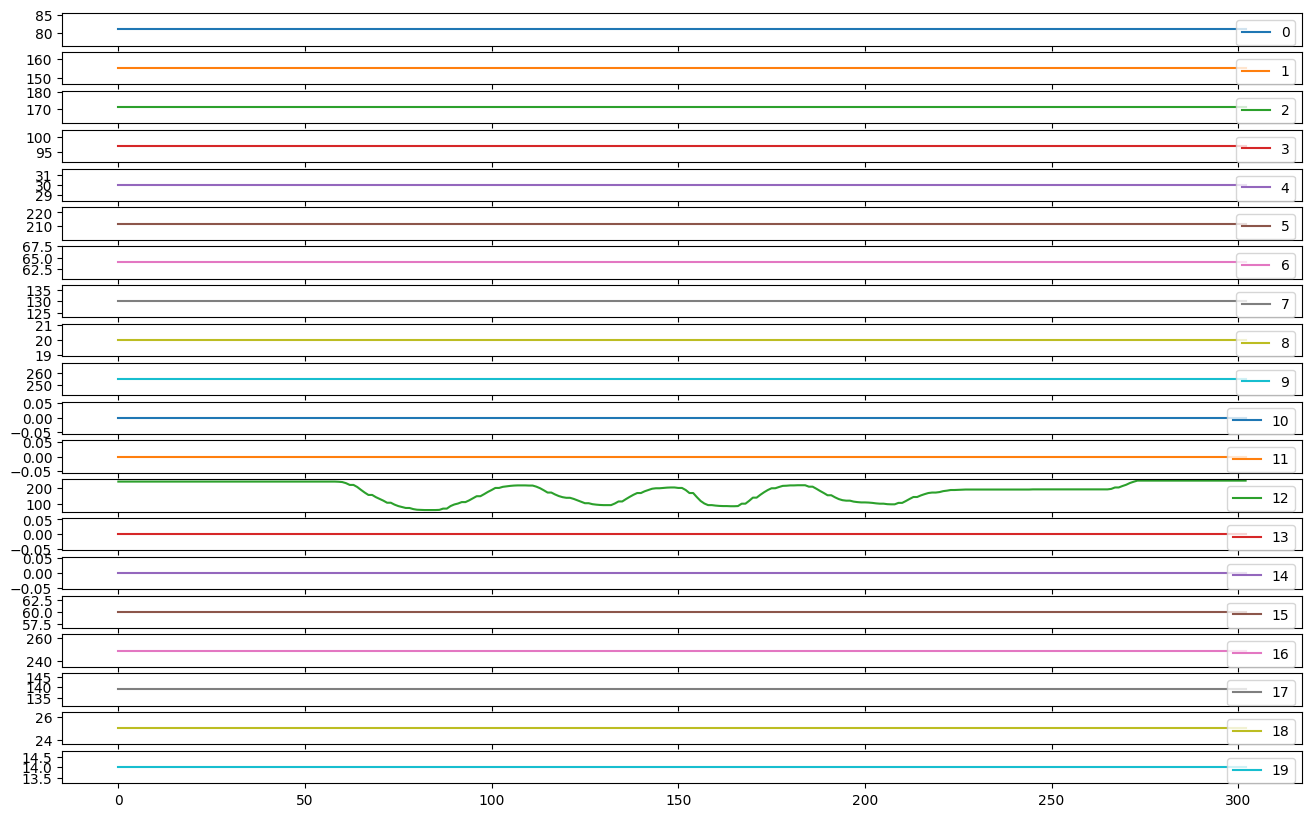

In [35]:
fig,ax = plt.subplots()
fig.set_size_inches(16, 10)
# df_decimaldat1dat14[[0,1,2,3,4,18,19]].plot(use_index=True,subplots=True, ax=ax) # use for color adjustments
# df_decimaldat1dat14[[14,15]].plot(use_index=True,subplots=True, ax=ax) # use for enhancer adjustments
# df_decimaldat1dat14[[5,16,17]].plot(use_index=True,subplots=True, ax=ax) # use for contrast
# df_decimaldat1dat14[[16]].plot(use_index=True,subplots=True, ax=ax) 
df_decimaldat1dat14.plot(use_index=True,subplots=True, ax=ax) # show all

# packet timing

In [80]:
df['datetime'] = pd.to_datetime(df['Time[s]'], unit='s')
_,dat0pkprops = signal.find_peaks((1-df[' DAT0']), plateau_size=[1], height=[0.5])
lefts = dat0pkprops['left_edges']
rights = dat0pkprops['right_edges']
dat0pkprops

{'plateau_sizes': array([746, 736, 751, 737, 750, 737, 746, 736, 748, 737, 748, 737, 752,
        737, 744, 736, 750, 737, 748, 737, 747, 736, 747, 737, 750, 737,
        754, 737, 751, 736, 749, 737, 750, 737, 744, 736, 749, 737, 750,
        737, 747, 737, 753, 736, 747, 737, 747, 737, 751, 736, 746, 737,
        751, 737, 746, 737, 745, 736, 753, 737, 750, 737, 749, 736, 749,
        737, 751, 737, 750, 737, 746, 736, 754, 737, 750, 737, 750, 736,
        744, 737, 753, 737, 746, 737, 746, 736, 755, 737, 751, 737, 751,
        736, 745, 737, 745, 737, 752, 737, 746, 736, 745, 737, 748, 737,
        749, 736, 749, 737, 751, 737, 747, 737, 746, 736, 752, 737, 748,
        737, 749, 736, 745, 737, 751, 737, 747, 737, 749, 736, 752, 737,
        751, 737, 751, 736, 745, 737, 750, 737, 745, 737, 749, 736, 745,
        737], dtype=int64),
 'left_edges': array([    335,   14344,   28343,   42356,   56355,   70367,   84366,
          98375,  112374,  126385,  140384,  154394,  168393,  1824

array([<Axes: xlabel='Time[s]'>, <Axes: xlabel='Time[s]'>,
       <Axes: xlabel='Time[s]'>], dtype=object)

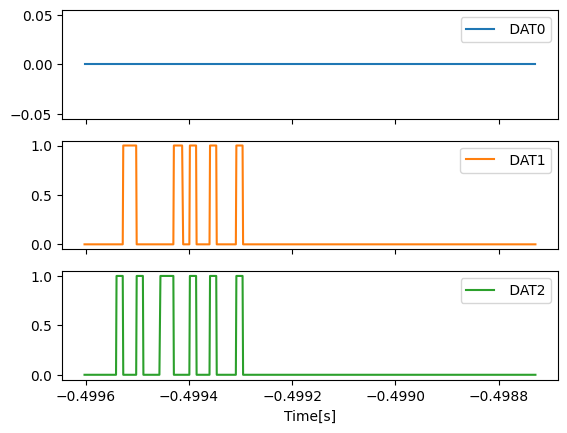

In [86]:

df.iloc[lefts[0]:rights[0]].plot(x='Time[s]', y=[' DAT0',' DAT1',' DAT2'], subplots=True)

In [96]:
dat0period = df.iloc[lefts]['datetime'].diff()
print("DAT0 Period Statisics")
print(dat0period.describe())
print("\nMean Period:", dat0period.mean().value * 1e-9 * 1e3, 'ms')

DAT0 Period Statisics
count                          143
mean     0 days 00:00:00.016651139
std      0 days 00:00:00.000000348
min      0 days 00:00:00.016650999
25%         0 days 00:00:00.016651
50%         0 days 00:00:00.016651
75%         0 days 00:00:00.016651
max      0 days 00:00:00.016652001
Name: datetime, dtype: object

Mean Period: 16.651139 ms


In [104]:
dat0falls = df.iloc[lefts]['datetime']
dat0rises = df.iloc[rights]['datetime']
falls_arr = dat0falls.to_numpy(np.float64) * 1e-9
rises_arr = dat0rises.to_numpy(np.float64) * 1e-9
dat0lowtimes = rises_arr - falls_arr
print("DAT0 Low Time Statistics")
print(pd.Series(dat0lowtimes).describe())
print("\nMean Low Time:", dat0lowtimes.mean() * 1e6, 'us')

DAT0 Low Time Statistics
count    1.440000e+02
mean     8.753958e-04
std      7.952601e-07
min      8.740000e-04
25%      8.750000e-04
50%      8.760000e-04
75%      8.760000e-04
max      8.760010e-04
dtype: float64

Mean Low Time: 875.3958402777747 us


In [108]:
dat0hightimes = falls_arr[1:] - rises_arr[:-1]
print("DAT0 High Time Statistics")
print(pd.Series(dat0hightimes).describe())
print("\nMean High Time:", dat0hightimes.mean() * 1e3, 'ms')

DAT0 High Time Statistics
count    1.430000e+02
mean     1.577575e-02
std      8.431103e-07
min      1.577500e-02
25%      1.577500e-02
50%      1.577500e-02
75%      1.577700e-02
max      1.577700e-02
dtype: float64

Mean High Time: 15.775748244755247 ms


In [135]:
# want to figure out the average aount of time dat0 is low before dat14 clocks in the first byte
dat0waittimes = []
for start,end in zip(lefts,rights):
    # print(start,end)
    lowchunk = df.iloc[start:end]
    dat14diffs = lowchunk[' DAT14'].diff()
    if dat14diffs.isin([1]).any(): # if dat14 goes high in this packet
        # print('data is in this packet')
        row_where_dat14_rises = dat14diffs.idxmax()
        time = lowchunk.loc[row_where_dat14_rises, 'datetime'] - lowchunk.iloc[0]['datetime']
        dat0waittimes.append(time)
    else: # dat14 does not go high in this packet
        # print('no data in this packet!')
        continue
dat0waittimes = pd.Series(dat0waittimes)
print("Time DAT0 Low until DAT14 High Statistics")
print(dat0waittimes.describe())
print("\nMean Time:", dat0waittimes.mean().value * 1e-9 * 1e6, 'us')

Time DAT0 Low until DAT14 High Statistics
count                           72
mean     0 days 00:00:00.000068402
std      0 days 00:00:00.000005999
min         0 days 00:00:00.000065
25%         0 days 00:00:00.000066
50%         0 days 00:00:00.000067
75%         0 days 00:00:00.000068
max         0 days 00:00:00.000112
dtype: object

Mean Time: 68.402 us


In [152]:
# Figure out the rate at which bytes are sent in each packet for 2 scenarios
# 1. assuming there's 20 bytes (what is actually shown in my observations)
# 2. assuming there's 22 bytes (what seems to be possible with the additions of 2 more pulses. but which lines will pulse????)
transmissiontimes = []
for start,end in zip(lefts,rights):
    # print(start,end)
    lowchunk = df.iloc[start:end]
    dat14diffs = lowchunk[' DAT14'].diff()
    if dat14diffs.isin([1]).any(): # if dat14 goes high in this packet
        # print('data is in this packet')
        row_where_dat14_rises = dat14diffs.idxmax()
        # reverse the diffs
        dat14diffs = dat14diffs.iloc[::-1]
        last_row_where_dat14_falls = dat14diffs.idxmax()
        time = lowchunk.loc[last_row_where_dat14_falls, 'datetime'] - lowchunk.loc[row_where_dat14_rises, 'datetime']
        transmissiontimes.append(time)
    else: # dat14 does not go high in this packet
        # print('no data in this packet!')
        continue
transmissiontimes = pd.Series(transmissiontimes)
print("Transmission Time Statistics")
print(transmissiontimes.describe())
print("\nMean Transmission Time:", transmissiontimes.mean().value * 1e-9 *1e6, 'us')
bytetimes = transmissiontimes.to_numpy(np.float64) / 20
print("\nByte Period Statistics")
print(pd.Series(bytetimes * 1e-9).describe())
print("\nMean Byte Period:", bytetimes.mean() * 1e-9 * 1e6, 'us/byte')

Transmission Time Statistics
count                           72
mean     0 days 00:00:00.000291013
std      0 days 00:00:00.000000117
min         0 days 00:00:00.000291
25%         0 days 00:00:00.000291
50%         0 days 00:00:00.000291
75%         0 days 00:00:00.000291
max         0 days 00:00:00.000292
dtype: object

Mean Transmission Time: 291.01300000000003 us

Byte Period Statistics
count    7.200000e+01
mean     1.455070e-05
std      5.892396e-09
min      1.455000e-05
25%      1.455000e-05
50%      1.455000e-05
75%      1.455000e-05
max      1.460000e-05
dtype: float64

Mean Byte Period: 14.550695833333334 us/byte


Note!!! This is just how long between bytes. This is not the amount of time that dat13 or dat 14 need to be high to clock in a byte.  
Typical lengths for those pulses are 3us.

In [154]:
# Getting average pulse length for dat13 and dat14
_,dat14pkprops = signal.find_peaks(df[' DAT14'], plateau_size=[1])
_,dat13pkprops = signal.find_peaks(df[' DAT13'], plateau_size=[1])


# Investigating Standalone MCU Configuration and ADV_MODE

In [33]:
fpath = "F:\\pp1_data_processing\\2023-06-06_12-38-17  dat bus in standalone mode with adv mode cycling.csv"
df = pd.read_csv(fpath)

In [34]:
df.columns

Index(['Time[s]', ' !ADV_MODE', ' DAT0', ' DAT1', ' DAT2', ' DAT3', ' DAT4',
       ' DAT5', ' DAT6', ' DAT7', ' DAT8', ' DAT9', ' DAT10', ' DAT11',
       ' DAT12', ' DAT13', ' DAT14'],
      dtype='object')

In [35]:
# Using the !ADV_MODE column, we will make a column that represents which mode we're in
# There are 5 possible modes. 0=normal, 1-4 = some advanced mode.
advdiff = df[' !ADV_MODE'].diff()
advdiff = advdiff == -1
print(advdiff.value_counts())
advdiff = advdiff.cumsum()
advdiff = advdiff.apply(lambda x: x % 5)
df['mode'] = advdiff

 !ADV_MODE
False    133943
True         10
Name: count, dtype: int64


In [23]:
# get falling and rising edges of dat 0
_,dat0pkprops = signal.find_peaks((1-df[' DAT0']), plateau_size=[1], height=[0.5])
lefts = dat0pkprops['left_edges']
rights = dat0pkprops['right_edges']
dat0pkprops

{'plateau_sizes': array([ 1, 81, 78, ..., 79,  1, 79], dtype=int64),
 'left_edges': array([     1,      3,     85, ..., 133791, 133871, 133873], dtype=int64),
 'right_edges': array([     1,     83,    162, ..., 133869, 133871, 133951], dtype=int64),
 'peak_heights': array([1., 1., 1., ..., 1., 1., 1.])}

In [36]:
# make a new column that represents DAT13 | DAT14
df['latch'] = df[' DAT13'] | df[' DAT14']
df['latch']

0         0
1         0
2         0
3         0
4         0
         ..
133948    0
133949    1
133950    0
133951    0
133952    0
Name: latch, Length: 133953, dtype: int64

In [126]:
# extract data as a sequence of bytes
dflatched = df[df['latch'].diff() == 1].copy() # latch on rising edge of 'latch'
# extract value
bits = dflatched.loc[:,' DAT1':' DAT8'].to_numpy()
value_arr = np.sum(bits * (2**np.arange(7,-1,-1)), axis=1)
dflatched['value'] = value_arr
# extract address
bits = dflatched.loc[:, ' DAT9':' DAT12'].to_numpy()
addr_arr = np.sum(bits * (2**np.arange(3,-1,-1)), axis=1)
dflatched['address'] = addr_arr
# bank A or B
dflatched['bank'] = dflatched.apply(lambda x: 'A' if x.iloc[15] == 1 else 'B', axis=1)
dflatched = dflatched[['Time[s]', ' !ADV_MODE', ' DAT0', ' DAT13',' DAT14','value','address','bank','mode']]

In [127]:
grouped = dflatched.groupby(['address', 'bank'])
len(grouped.groups.keys())
timecolidx = []
valuecolidx = []
modecolidx = []
# create a dataframe with one column per key
groupdf = pd.DataFrame()
colidx=0
for key in grouped.groups.keys():
    groupdf[str(key[0])+key[1]+'time'] = grouped.get_group(key)['Time[s]']
    timecolidx.append(colidx)
    colidx+=1
    groupdf[str(key[0])+key[1]+'value'] = grouped.get_group(key)['value']
    valuecolidx.append(colidx)
    colidx+=1
    groupdf[str(key[0])+key[1]+'mode'] = grouped.get_group(key)['mode']
    modecolidx.append(colidx)
    colidx+=1

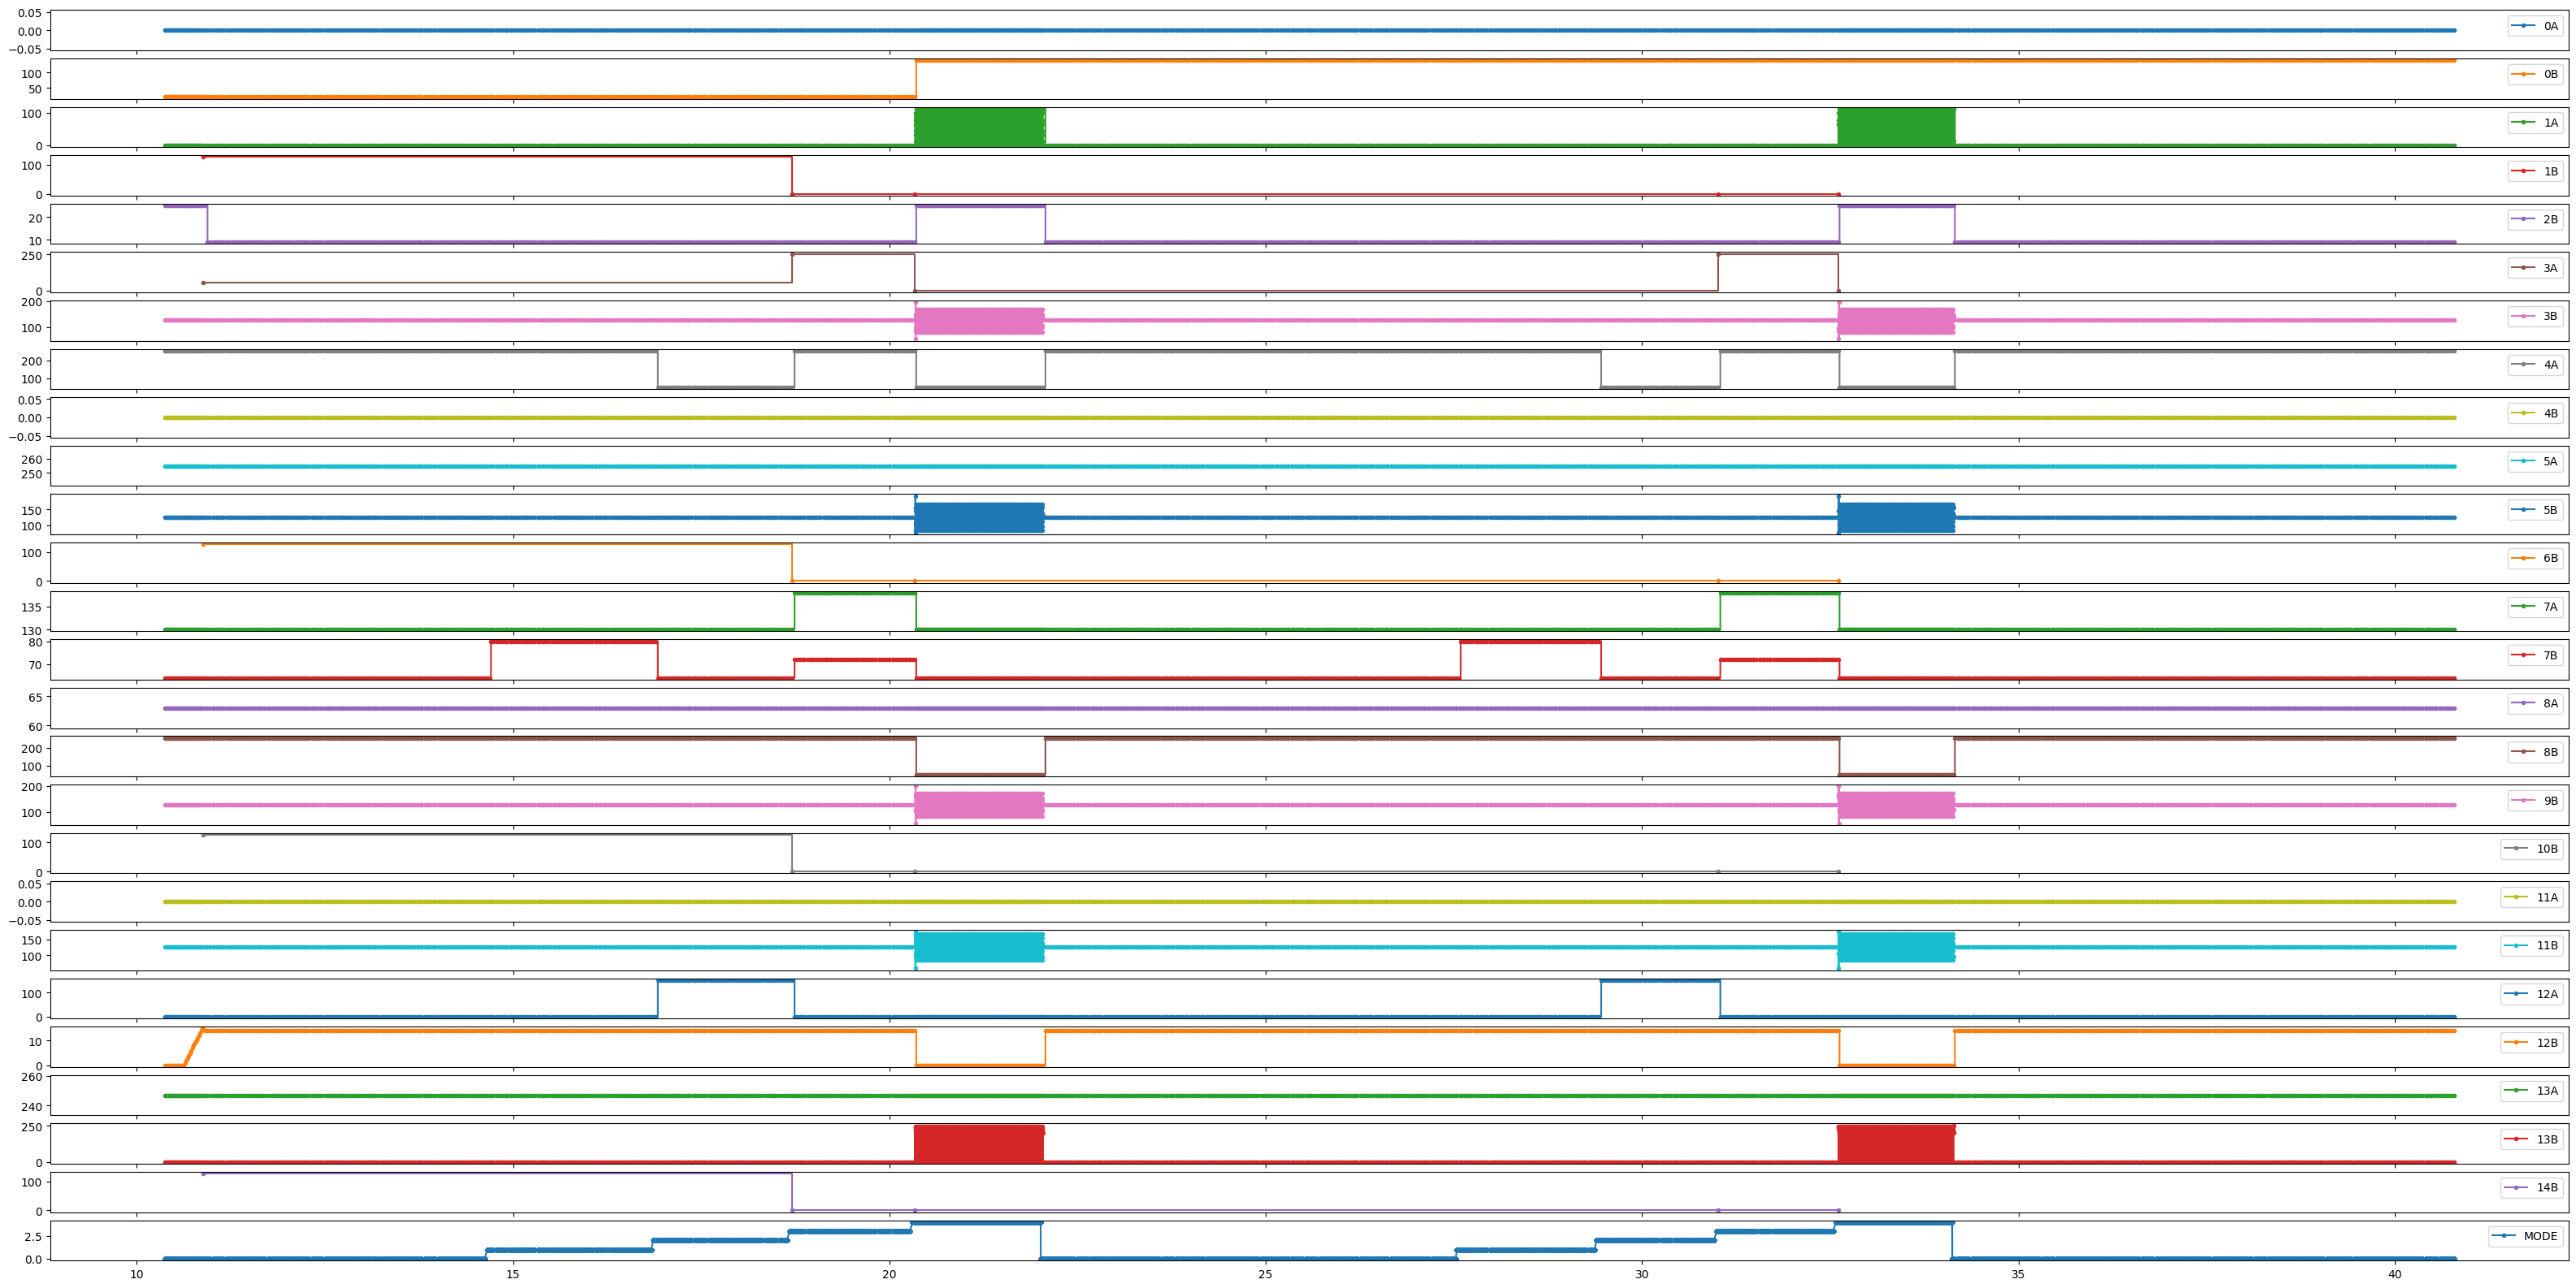

In [128]:
styles = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig,axs = plt.subplots(nrows=len(grouped.groups.keys()) + 1, ncols=1, figsize=(40,20), sharex=True)
i = 0
for key in grouped.groups.keys():
    datadf = grouped.get_group(key)
    axs[i].plot(datadf['Time[s]'],datadf['value'],label=str(key[0])+key[1], marker='.',drawstyle='steps-post', color=styles[i%len(styles)])
    axs[i].legend()
    i+=1
axs[i].plot(dflatched['Time[s]'],dflatched['mode'],label='MODE', marker='.')
axs[i].legend()
plt.show()

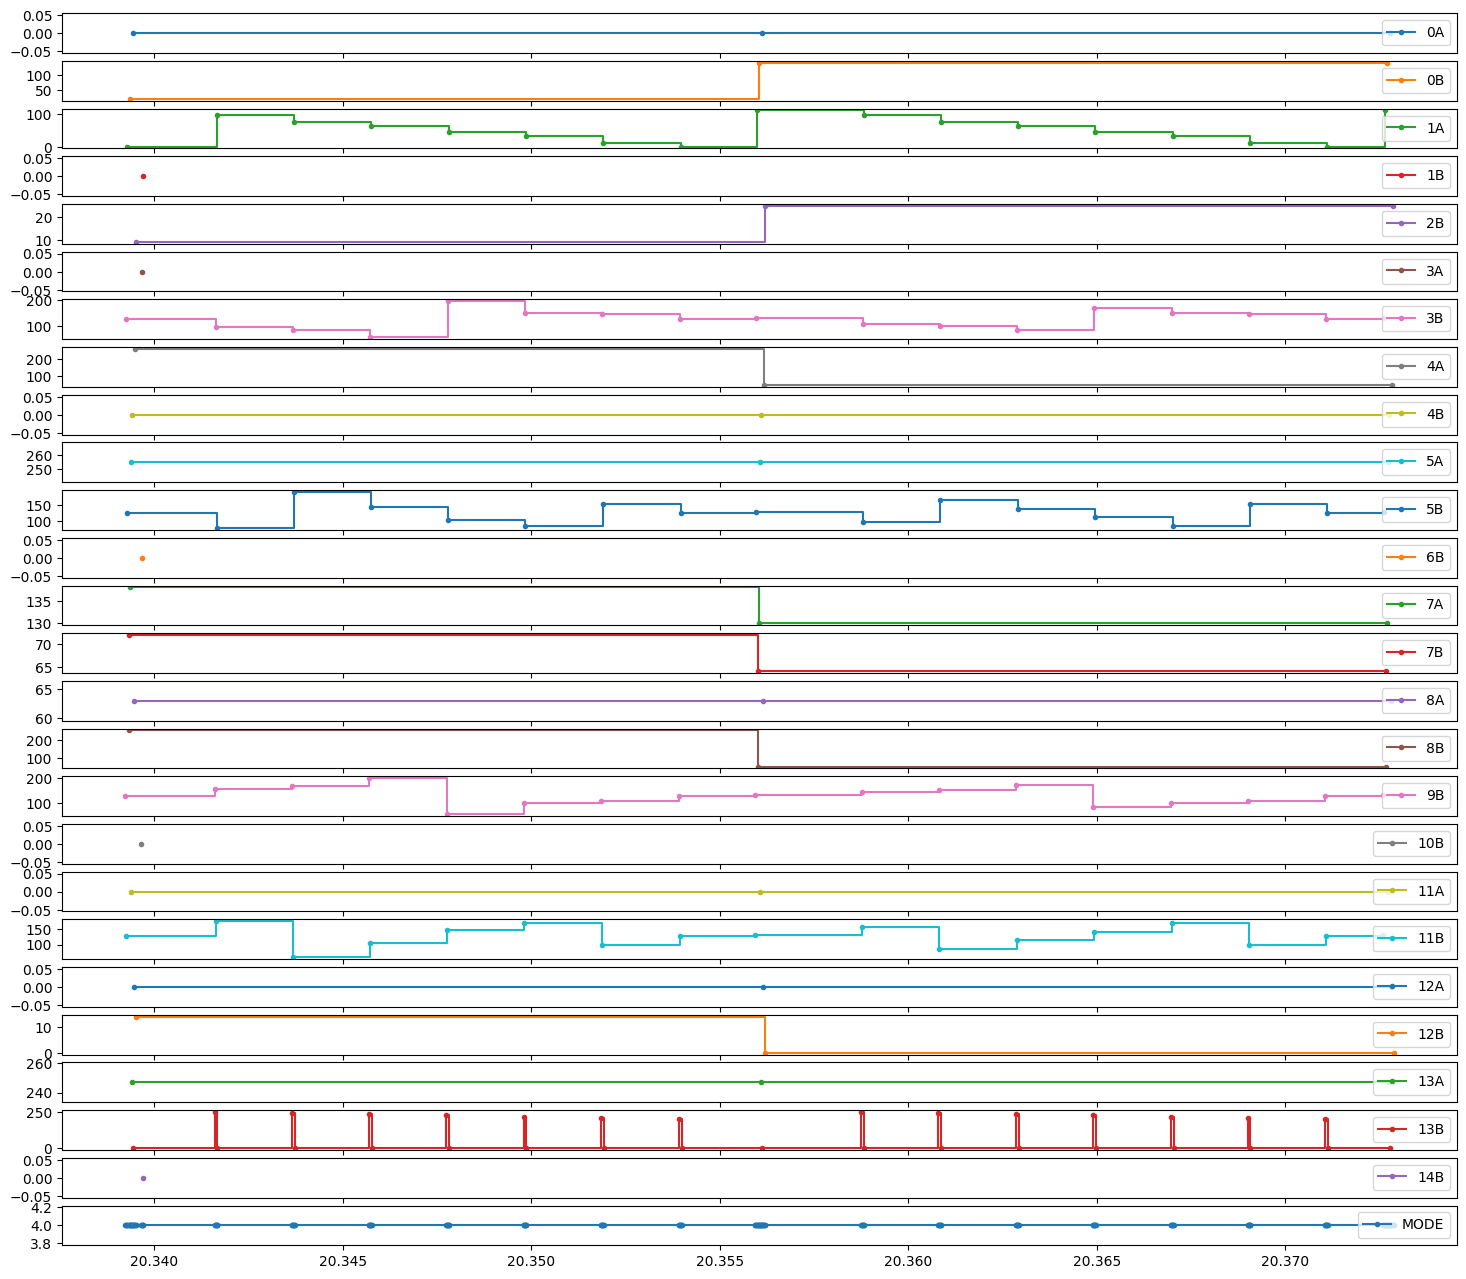

In [135]:
styles = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

t0 = 20.325
# t0 = 20.3415
t1 = 20.375
# t1 = 20.34175

fig,axs = plt.subplots(nrows=len(grouped.groups.keys()) + 1, ncols=1, figsize=(18,16), sharex=True)
i = 0
for key in grouped.groups.keys():
    datadf = grouped.get_group(key)
    axs[i].plot(datadf['Time[s]'].loc[(datadf['Time[s]']>t0) & (datadf['Time[s]']<t1)],datadf['value'].loc[(datadf['Time[s]']>t0) & (datadf['Time[s]']<t1)],label=str(key[0])+key[1], marker='.',drawstyle='steps-post', color=styles[i%len(styles)])
    axs[i].legend()
    i+=1
axs[i].plot(dflatched['Time[s]'].loc[(dflatched['Time[s]']>t0) & (dflatched['Time[s]']<t1)],dflatched['mode'].loc[(dflatched['Time[s]']>t0) & (dflatched['Time[s]']<t1)],label='MODE', marker='.')
axs[i].legend()
plt.show()

## Note different values of 13B during mode=4

In [98]:
addr13b = grouped.get_group((13,'B'))
addr13b[addr13b['value']>0]

,Time[s],!ADV_MODE,DAT0,DAT13,DAT14,value,address,bank,mode
29304,20.341603,0,1,0,1,248,13,B,4
29334,20.343650,0,1,0,1,240,13,B,4
29363,20.345698,0,1,0,1,232,13,B,4
29393,20.347748,0,1,0,1,224,13,B,4
29422,20.349797,0,1,0,1,216,13,B,4
...,...,...,...,...,...,...,...,...,...
114717,34.131581,0,1,0,1,224,13,B,0
114746,34.133609,0,1,0,1,216,13,B,0
114776,34.135655,0,1,0,1,208,13,B,0
114805,34.137702,0,1,0,1,200,13,B,0


In [112]:
addr13b[addr13b['value']>0]['value'].value_counts()

value
248    194
240    194
232    194
224    194
216    194
208    194
200    194
254      1
Name: count, dtype: int64

In [133]:
addr13b[addr13b['value']==254]


,Time[s],!ADV_MODE,DAT0,DAT13,DAT14,value,address,bank,mode
114912,34.139796,0,0,0,1,254,13,B,0


<Axes: xlabel='Time[s]'>

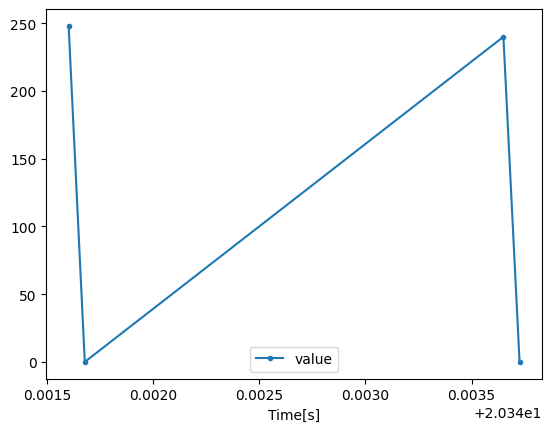

In [118]:
addr13b.loc[(addr13b['Time[s]']>20.3414) & (addr13b['Time[s]']<20.344)].plot(x='Time[s]', y='value',kind='line', marker='.')


In [119]:
addr13b.loc[(addr13b['Time[s]']>20.3414) & (addr13b['Time[s]']<20.344)]

,Time[s],!ADV_MODE,DAT0,DAT13,DAT14,value,address,bank,mode
29304,20.341603,0,1,0,1,248,13,B,4
29329,20.341679,0,1,0,1,0,13,B,4
29334,20.343650,0,1,0,1,240,13,B,4
29358,20.343726,0,1,0,1,0,13,B,4
